In [1]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
from monai.data import ImageDataset
from monai.transforms import Resize, EnsureChannelFirst, Compose
from torch.utils.data import DataLoader

from evaluate_util import get_model

C:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
exp_name = "2024_03_08__11_14_40"
exp_path = "experiments/" + exp_name + "/"
with open(exp_path + "config.json", 'r') as file:
    config = json.load(file)

model_config = config["model_config"]

transformer = Compose([EnsureChannelFirst(),
                       Resize(config["image_size"])])

val_image_path = "data/REFUGE2/Validation/Images/"
val_dm_path = "data/REFUGE2/Validation/Disc_Masks/"

number_of_images = 1

val_data = ImageDataset(image_files=[val_image_path + file for file in os.listdir(val_image_path)[:number_of_images]],
                        transform=transformer,
                        seg_files=[val_dm_path + file for file in os.listdir(val_dm_path)[:number_of_images]],
                        seg_transform=transformer)

train_dataloader = DataLoader(val_data, batch_size=config["batch_size"], shuffle=True)

print("config of experiment " + exp_name + "\n-----------------------------------------")
for key in config.keys():
    if isinstance(config[key], dict):
        for sub_key in config[key].keys():
            print("\t" + sub_key + ": " + str(config[key][sub_key]))
    else:
        print(key + ": " + str(config[key]))

config of experiment 2024_03_08__11_14_40
-----------------------------------------
	spatial_dims: 2
	in_channels: 3
	out_channels: 2
	channels: [16, 32, 64, 128, 256]
	strides: [2, 2, 2, 2]
	num_res_units: 2
image_size: [1024, 1024]
batch_size: 32
epochs: 100


In [4]:
def plot_model_output(sample):
    fig, ((img1, img2), (img3, img4), (img5, img6)) = plt.subplots(3, 2, layout="constrained")

    img1.set_title("original image")
    img1.imshow(sample[0][0].permute(1, 2, 0) / 255)
    img1.set_axis_off()

    disc_image = np.stack([np.array(sample[1][0]),
                           np.zeros(shape=(sample[1].shape[1], sample[1].shape[2])),
                           np.array(sample[1][1])])

    img2.set_title("model output")
    img2.imshow(np.transpose(disc_image, (1, 2, 0)))
    img2.set_axis_off()

    img3.set_title("model output, channel 0")
    img3.imshow(sample[1][0]/255, cmap="gray")
    img3.set_axis_off()

    img4.set_title("model output, channel 1")
    img4.imshow(sample[1][1]/255, cmap="gray")
    img4.set_axis_off()

    img5.set_title("desired output, channel 0")
    img5.imshow(sample[2][0, 0]/255, cmap="gray")
    img5.set_axis_off()

    img6.set_title("desired output, channel 1")
    img6.imshow(sample[2][0, 1]/255, cmap="gray")
    img6.set_axis_off()
    plt.show()

In [5]:
model, _ = get_model(exp_path, model_config)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


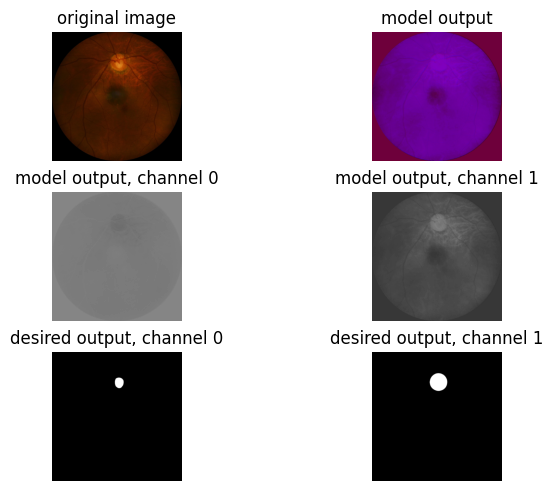

In [6]:
for batch in train_dataloader:
    new_images = model(batch[0])
    plot_model_output((batch[0], new_images[0].detach(), batch[1]))
    break